In [62]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from pathlib import Path
import numpy as np
import seaborn as sns
from scipy import stats
from typing import Dict, Tuple, List
import warnings
import nilearn.plotting as plotting
import pickle
import scipy.io as sio
from pprint import pprint
import nibabel as nib

In [59]:
# Global configurations
code_directory = '/Users/tereza/nishant/atlas/atlas_work_terez/atlas_harmonization/code'
os.chdir(code_directory)
base_path_results = '../results'
base_path_data = '../Data'

In [26]:
def inspect_region_features():
        
    # Load data
    print("Loading data...")
    hup_region_features = pd.read_csv(os.path.join(base_path_results, 'ge_go_hup_region_features.csv'))
    mni_region_features = pd.read_csv(os.path.join(base_path_results, 'mni_region_features.csv'))
    
    # Print basic information
    print("\nDataset Overview:")
    print("=" * 50)
    print(f"HUP Region Features shape: {hup_region_features.shape}")
    print(f"MNI Region Features shape: {mni_region_features.shape}")
    
    # Inspect columns
    print("\nColumns in datasets:")
    print("=" * 50)
    print("HUP columns:", hup_region_features.columns.tolist())
    print("MNI columns:", mni_region_features.columns.tolist())
    
    # Feature columns (excluding metadata columns)
    feature_columns = [
        'deltaRel_mean', 
        'thetaRel_mean', 
        'alphaRel_mean', 
        'betaRel_mean',
        'gammaRel_mean',
        'entropy_1min_mean',
        'entropy_fullts_mean'
    ]
    
    # Analyze patient and region coverage
    print("\nPatient and Region Coverage:")
    print("=" * 50)
    print("HUP Dataset:")
    print(f"Number of unique patients: {hup_region_features['patient_id'].nunique()}")
    print(f"Number of unique regions: {hup_region_features['roi'].nunique()}")
    print("\nMNI Dataset:")
    print(f"Number of unique patients: {mni_region_features['patient_id'].nunique()}")
    print(f"Number of unique regions: {mni_region_features['roi'].nunique()}")
    
    # Analyze common regions
    common_regions = set(hup_region_features['roi'].unique()) & set(mni_region_features['roi'].unique())
    print(f"\nNumber of common regions between datasets: {len(common_regions)}")
    
    # Feature statistics by region
    print("\nFeature Statistics by Dataset:")
    print("=" * 50)
    
    for dataset_name, dataset in [("HUP", hup_region_features), ("MNI", mni_region_features)]:
        print(f"\n{dataset_name} Dataset Feature Statistics:")
        feature_stats = dataset[feature_columns].agg(['mean', 'std', 'min', 'max'])
        print(feature_stats)
    
    # Analyze patient counts per region
    print("\nPatient Counts per Region:")
    print("=" * 50)
    
    def get_region_patient_counts(df):
        return df.groupby('roi')['patient_id'].nunique().sort_values(ascending=False)
    
    print("\nHUP Dataset - Top 10 regions by patient count:")
    print(get_region_patient_counts(hup_region_features).head(10))
    
    print("\nMNI Dataset - Top 10 regions by patient count:")
    print(get_region_patient_counts(mni_region_features).head(10))
    
    # Identify regions with low patient counts
    min_patients = 5  # Threshold for minimum patients
    
    print(f"\nRegions with <{min_patients} patients:")
    print("=" * 50)
    
    for dataset_name, dataset in [("HUP", hup_region_features), ("MNI", mni_region_features)]:
        patient_counts = get_region_patient_counts(dataset)
        low_count_regions = patient_counts[patient_counts < min_patients]
        print(f"\n{dataset_name} Dataset:")
        print(low_count_regions)
    
    # Save detailed analysis to file
    output_file = os.path.join(base_path_results, 'region_features_analysis.txt')
    print(f"\nSaving to: {output_file}")
    
    with open(output_file, 'w') as f:
        f.write("Region Features Analysis\n")
        f.write("=" * 50 + "\n\n")
        
        # Write patient counts per region
        f.write("Patient Counts per Region:\n")
        f.write("-" * 30 + "\n")
        f.write("\nHUP Dataset:\n")
        f.write(get_region_patient_counts(hup_region_features).to_string())
        f.write("\n\nMNI Dataset:\n")
        f.write(get_region_patient_counts(mni_region_features).to_string())
        
        # Write feature correlations
        f.write("\n\nFeature Correlations:\n")
        f.write("-" * 30 + "\n")
        f.write("\nHUP Dataset:\n")
        f.write(hup_region_features[feature_columns].corr().to_string())
        f.write("\n\nMNI Dataset:\n")
        f.write(mni_region_features[feature_columns].corr().to_string())

# if __name__ == "__main__":
#     inspect_region_features()

Cohen's d with bootstrap confidence intervals

# For each iteration:
1. Resample from group1 with replacement
2. Resample from group2 with replacement
3. Compute Cohen's d for these resamples
4. Store the result

# After all iterations:
5. Sort the bootstrap estimates
6. Take percentiles for confidence intervals
   - For 95% CI: 2.5th and 97.5th percentiles

In [ ]:
def compute_cohens_d(group1: np.ndarray, group2: np.ndarray) -> float:
    """
    Compute Cohen's d effect size between two groups.
    
    Parameters:
    -----------
    group1, group2 : np.ndarray
        Arrays containing measurements for each group
        
    Returns:
    --------
    float
        Cohen's d effect size
    """
    n1, n2 = len(group1), len(group2)
    var1, var2 = np.var(group1, ddof=1), np.var(group2, ddof=1)
    
    # Pooled standard deviation
    pooled_sd = np.sqrt((var1 + var2) / 2)
    
    # Mean difference
    mean_diff = np.mean(group1) - np.mean(group2)
    
    # Cohen's d
    d = mean_diff / pooled_sd if pooled_sd != 0 else 0
    
    return d

def bootstrap_cohens_d(group1: np.ndarray, group2: np.ndarray, 
                      n_iterations: int = 1000, 
                      confidence_level: float = 0.95) -> Tuple[float, Tuple[float, float]]:
    """
    Compute Cohen's d with bootstrap confidence intervals.
    
    Parameters:
    -----------
    group1, group2 : np.ndarray
        Arrays containing measurements for each group
    n_iterations : int
        Number of bootstrap iterations
    confidence_level : float
        Confidence level for the intervals (default: 0.95)
        
    Returns:
    --------
    Tuple[float, Tuple[float, float]]
        (Cohen's d, (lower CI, upper CI))
    """
    # Original Cohen's d
    d_orig = compute_cohens_d(group1, group2)
    
    # Bootstrap samples
    n1, n2 = len(group1), len(group2)
    d_boots = []
    
    for _ in range(n_iterations):
        boot1 = np.random.choice(group1, size=n1, replace=True)
        boot2 = np.random.choice(group2, size=n2, replace=True)
        d_boots.append(compute_cohens_d(boot1, boot2))
    
    # Compute confidence intervals
    ci_lower = np.percentile(d_boots, (1 - confidence_level) * 100 / 2)
    ci_upper = np.percentile(d_boots, 100 - (1 - confidence_level) * 100 / 2)
    
    return d_orig, (ci_lower, ci_upper)

def analyze_effect_sizes(hup_features: pd.DataFrame, 
                        mni_features: pd.DataFrame, 
                        min_patients: int = 5) -> Tuple[Dict, Dict]:
    """
    Compute Cohen's d and bootstrap CIs for all region-feature pairs.
    
    Parameters:
    -----------
    hup_features, mni_features : pd.DataFrame
        DataFrames containing features for each cohort
    min_patients : int
        Minimum number of patients required for analysis
        
    Returns:
    --------
    Tuple[Dict, Dict]
        (effect_sizes, confidence_intervals)
    """
    # Feature columns (excluding metadata)
    feature_columns = [
        'deltaRel_mean', 'thetaRel_mean', 'alphaRel_mean', 'betaRel_mean',
        'gammaRel_mean', 'entropy_1min_mean', 'entropy_fullts_mean'
    ]
    
    # Get common regions
    common_regions = set(hup_features['roi'].unique()) & set(mni_features['roi'].unique())
    
    # Initialize results dictionaries
    effect_sizes = {}
    confidence_intervals = {}
    
    for region in common_regions:
        # Get patient counts for each region
        hup_patients = hup_features[hup_features['roi'] == region]['patient_id'].nunique()
        mni_patients = mni_features[mni_features['roi'] == region]['patient_id'].nunique()
        
        # Skip regions with too few patients
        if hup_patients < min_patients or mni_patients < min_patients:
            continue
            
        effect_sizes[region] = {}
        confidence_intervals[region] = {}
        
        for feature in feature_columns:
            hup_data = hup_features[hup_features['roi'] == region][feature].values
            mni_data = mni_features[mni_features['roi'] == region][feature].values
            
            # Compute Cohen's d and bootstrap CIs
            d, (ci_lower, ci_upper) = bootstrap_cohens_d(hup_data, mni_data)
            
            effect_sizes[region][feature] = d
            confidence_intervals[region][feature] = (ci_lower, ci_upper)
    
    return effect_sizes, confidence_intervals

In [30]:
def visualize_effect_sizes(effect_sizes: Dict, 
                           confidence_intervals: Dict,
                           output_path: str = None):
    """
    Create visualizations for effect sizes and confidence intervals.
    """
    # Convert dictionaries to DataFrame
    df_list = []
    for region in effect_sizes:
        for feature in effect_sizes[region]:
            d = effect_sizes[region][feature]
            ci_lower, ci_upper = confidence_intervals[region][feature]
            df_list.append({
                'Region': region,
                'Feature': feature,
                'Cohens_d': d,
                'CI_lower': ci_lower,
                'CI_upper': ci_upper
            })

    df = pd.DataFrame(df_list)

    # Define consistent feature ordering and mapping
    feature_order = [
        'deltaRel_mean', 
        'thetaRel_mean', 
        'alphaRel_mean', 
        'betaRel_mean',
        'gammaRel_mean', 
        'entropy_1min_mean', 
        'entropy_fullts_mean'
    ]

    feature_name_mapping = {
        'deltaRel_mean': 'delta',
        'thetaRel_mean': 'theta', 
        'alphaRel_mean': 'alpha',
        'betaRel_mean': 'beta',
        'gammaRel_mean': 'gamma',
        'entropy_1min_mean': 'entropy 1min',
        'entropy_fullts_mean': 'entropy full'
    }

    # 1. Heatmap of effect sizes
    plt.figure(figsize=(12, 8))

    # Rename columns for display
    heatmap_data = df.pivot(index='Region', columns='Feature', values='Cohens_d')
    # Reorder columns according to feature_order
    heatmap_data = heatmap_data[feature_order]
#     heatmap_data.columns = [
#     f"{feature_name_mapping[col]} ({freq_range})"
#     for col, freq_range in zip(feature_order, 
#                                ['0.5–4 Hz', '4–8 Hz', '8–13 Hz', '13–30 Hz', '30–80 Hz', 'Entropy (1 min)', 'Entropy (full)'])
# ]

#     # Create heatmap
#     sns.heatmap(heatmap_data, cmap='RdBu_r', center=0, 
#                 vmin=-1.5, vmax=1.5, annot=True, fmt='.2f',
#                 xticklabels=True, yticklabels=True)

#     # Rotate x-axis labels to horizontal for better readability
#     plt.xticks(rotation=0)
#     plt.title("Cohen's d Effect Sizes: HUP vs MNI")
#     plt.tight_layout()

    heatmap_data.columns = [feature_name_mapping[col] for col in heatmap_data.columns]

    # Create heatmap
    sns.heatmap(heatmap_data, cmap='RdBu_r', center=0, 
                vmin=-1.5, vmax=1.5, annot=True, fmt='.2f',
                xticklabels=True, yticklabels=True)

    plt.xticks(rotation=0)
    plt.title("Cohen's d Effect Sizes: HUP vs MNI")
    # plt.tight_layout()

    # Save heatmap
    # if output_path:
    #     plt.savefig(f"{output_path}/cohens_d_effect_sizes_heatmap.png", dpi=300, bbox_inches='tight')

    # 2. Forest plot with region names and ordered features
    plt.figure(figsize=(15, 12))  # Increased figure size to accommodate region names

    # Get unique regions and create y-axis positions
    unique_regions = df['Region'].unique()
    y_positions = np.arange(len(unique_regions))

    # Create color cycle for features
    colors = plt.cm.tab10(np.linspace(0, 1, len(feature_order)))

    for idx, feature in enumerate(feature_order):
        feature_data = df[df['Feature'] == feature].copy()
        # Map regions to y-positions
        feature_data['y_pos'] = feature_data['Region'].map({region: i for i, region in enumerate(unique_regions)})

        plt.errorbar(feature_data['Cohens_d'], 
                     feature_data['y_pos'],
                     xerr=[feature_data['Cohens_d'] - feature_data['CI_lower'],
                           feature_data['CI_upper'] - feature_data['Cohens_d']],
                     fmt='o', label=feature_name_mapping[feature], 
                     alpha=0.7, color=colors[idx])

    plt.axvline(x=0, color='black', linestyle='--', alpha=0.3)
    plt.xlabel("Cohen's d")
    plt.yticks(y_positions, unique_regions, fontsize=8)
    plt.title("Effect Sizes with 95% Confidence Intervals\n(Positive = Higher in HUP, Negative = Higher in MNI)")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    # plt.tight_layout()

    # Save forest plot
    # if output_path:
    #     plt.savefig(f"{output_path}/cohens_d_effect_sizes_forest.png", dpi=300, bbox_inches='tight')

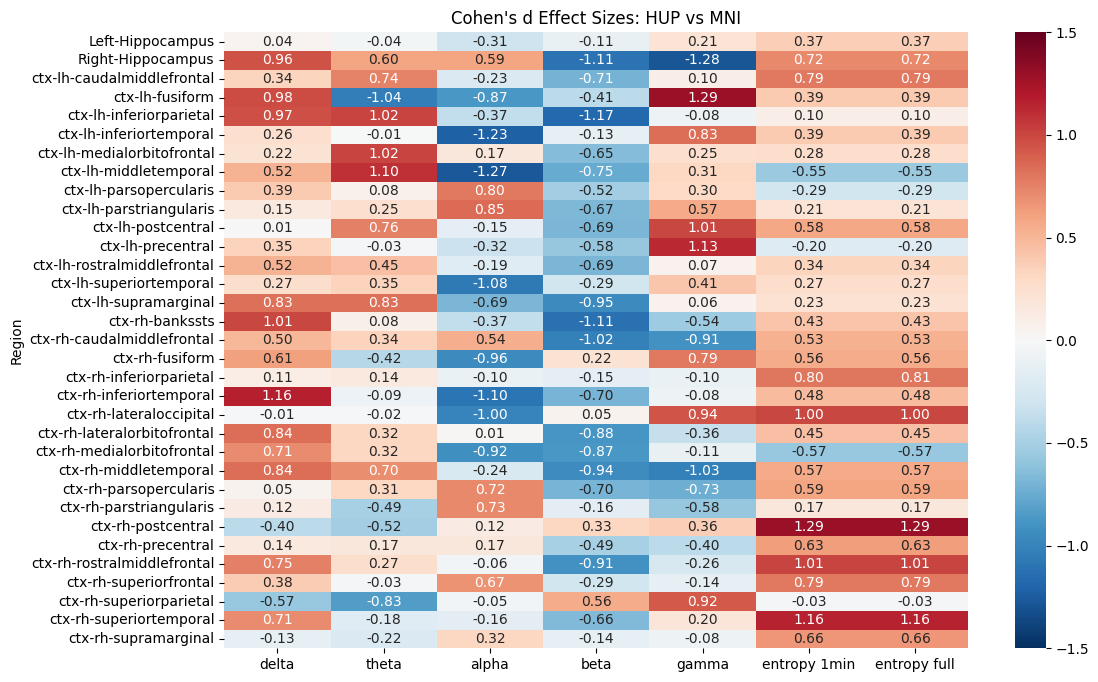

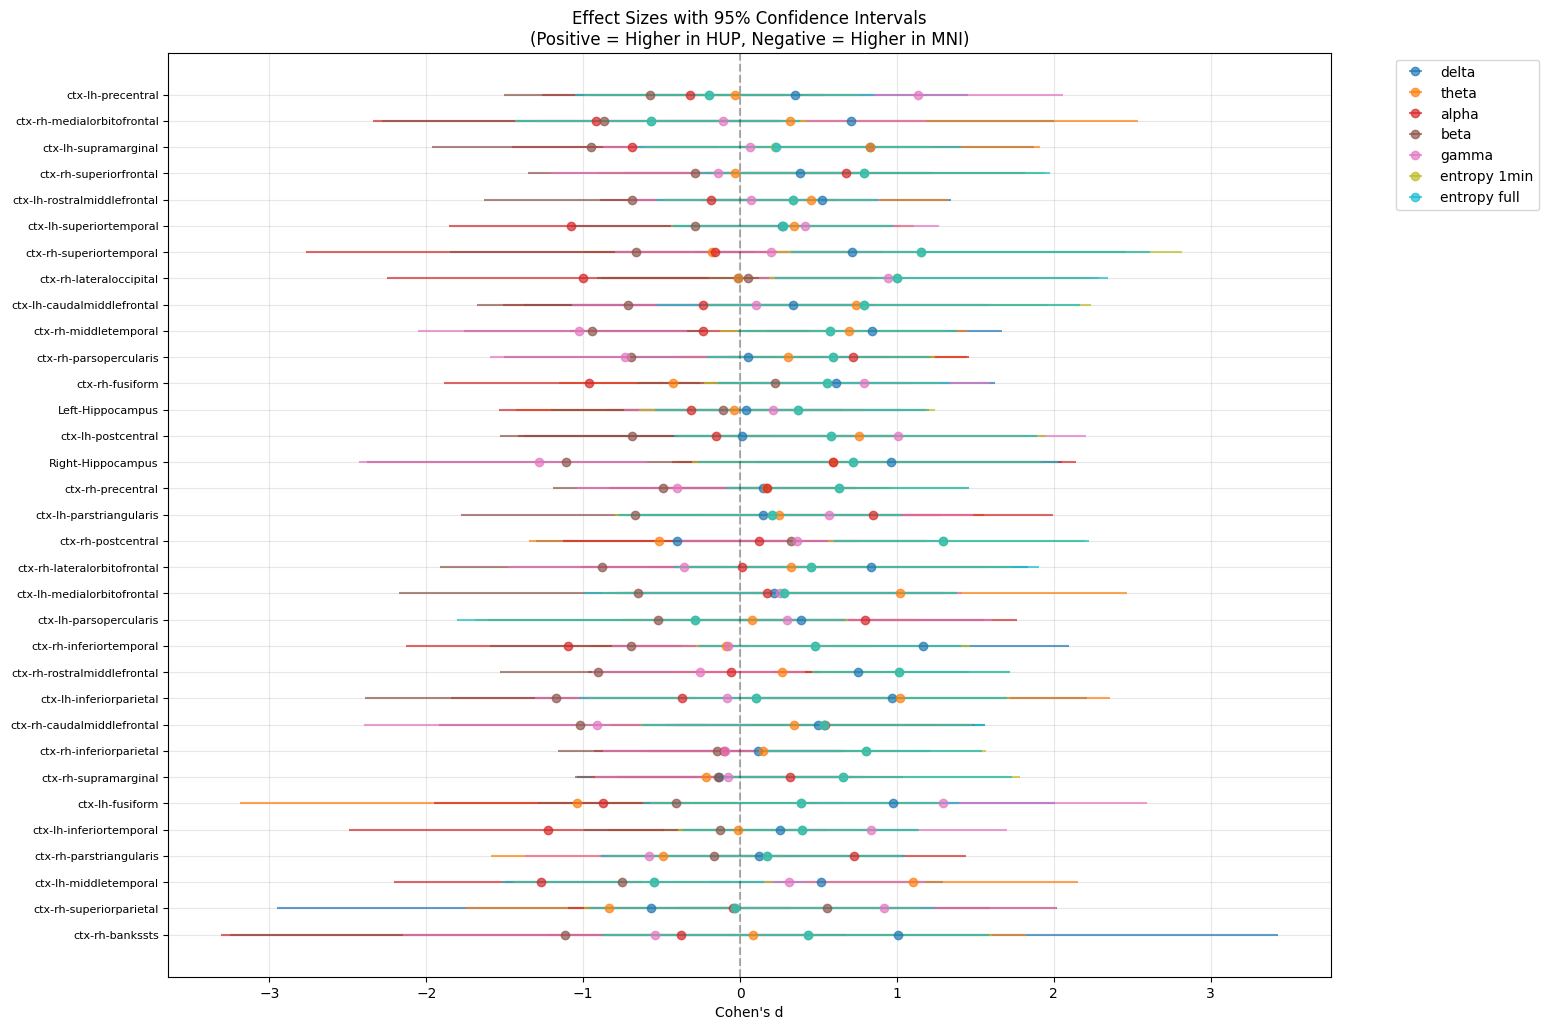

In [31]:
def main():
    """
    Main function to run the analysis.
    """
    # Load data (assuming these are already loaded as per your script)
    hup_region_features = pd.read_csv(os.path.join(base_path_results, 'ge_go_hup_region_features.csv'))
    mni_region_features = pd.read_csv(os.path.join(base_path_results, 'mni_region_features.csv'))
    
    # Compute effect sizes and confidence intervals
    effect_sizes, confidence_intervals = analyze_effect_sizes(
        hup_region_features, 
        mni_region_features,
        min_patients=5
    )
    
    # Create visualizations
    visualize_effect_sizes(
        effect_sizes, 
        confidence_intervals,
        output_path=base_path_results
    )
    
    # Save numerical results
    results_df = []
    for region in effect_sizes:
        for feature in effect_sizes[region]:
            d = effect_sizes[region][feature]
            ci_lower, ci_upper = confidence_intervals[region][feature]
            results_df.append({
                'Region': region,
                'Feature': feature,
                'Cohens_d': d,
                'CI_lower': ci_lower,
                'CI_upper': ci_upper
            })
    
    results_df = pd.DataFrame(results_df)
    results_df.to_csv(os.path.join(base_path_results, 'cohens_d_results.csv'), index=False)

if __name__ == "__main__":
    main()


Normality Test Summary:
Total region-feature pairs tested: 231
Normal distributions in both cohorts: 173 (74.9%)

Potentially problematic cases (p < 0.05):
--------------------------------------------------

ctx-rh-bankssts - alphaRel_mean:
  HUP: p=0.0300 (n=6)
  MNI: p=0.4772 (n=5)

ctx-rh-superiorparietal - deltaRel_mean:
  HUP: p=0.0049 (n=5)
  MNI: p=0.0867 (n=12)

ctx-lh-middletemporal - entropy_1min_mean:
  HUP: p=0.0062 (n=15)
  MNI: p=0.7925 (n=12)

ctx-lh-middletemporal - entropy_fullts_mean:
  HUP: p=0.0063 (n=15)
  MNI: p=0.7938 (n=12)

ctx-rh-parstriangularis - alphaRel_mean:
  HUP: p=0.0144 (n=10)
  MNI: p=0.9375 (n=11)

ctx-rh-parstriangularis - betaRel_mean:
  HUP: p=0.0113 (n=10)
  MNI: p=0.4041 (n=11)

ctx-rh-parstriangularis - gammaRel_mean:
  HUP: p=0.0180 (n=10)
  MNI: p=0.8082 (n=11)

ctx-lh-fusiform - deltaRel_mean:
  HUP: p=0.0036 (n=13)
  MNI: p=0.8624 (n=6)

ctx-lh-fusiform - alphaRel_mean:
  HUP: p=0.0007 (n=13)
  MNI: p=0.7792 (n=6)

ctx-lh-fusiform - betaR

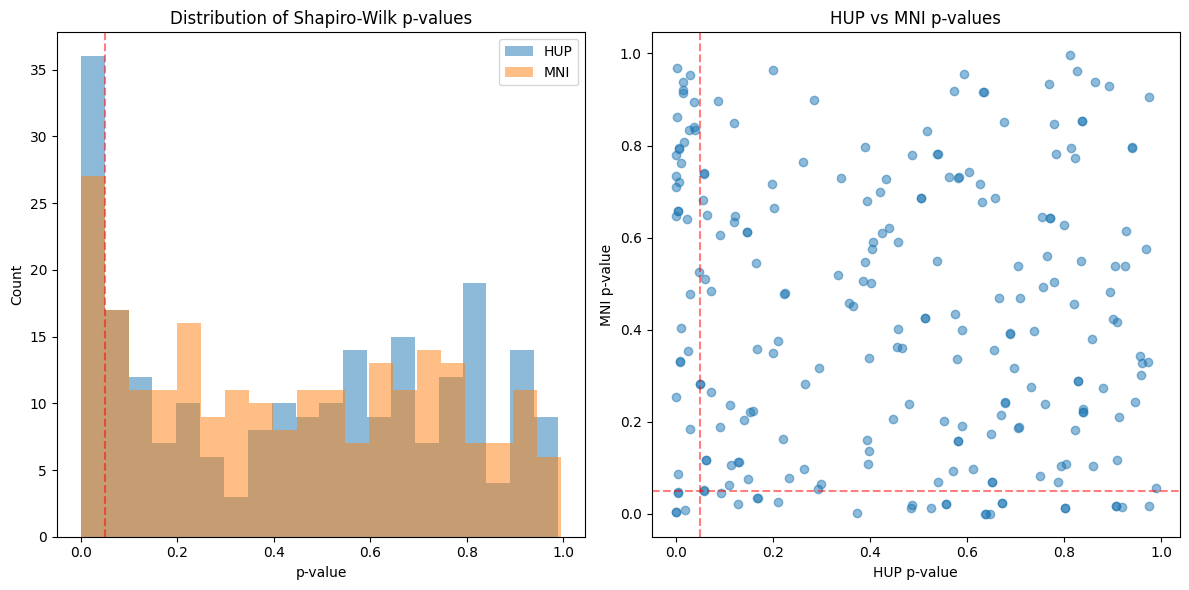

In [32]:
def check_normality_and_visualize(hup_features: pd.DataFrame, 
                                mni_features: pd.DataFrame,
                                min_patients: int = 5) -> Dict:
    """
    Check normality of features across regions for both HUP and MNI datasets.
    
    Parameters:
    -----------
    hup_features, mni_features : pd.DataFrame
        DataFrames containing features for each cohort
    min_patients : int
        Minimum number of patients required for analysis
        
    Returns:
    --------
    Dict
        Nested dictionary containing normality test results
    """
    # Feature columns (excluding metadata)
    feature_columns = [
        'deltaRel_mean', 'thetaRel_mean', 'alphaRel_mean', 'betaRel_mean',
        'gammaRel_mean', 'entropy_1min_mean', 'entropy_fullts_mean'
    ]
    
    # Get common regions
    common_regions = set(hup_features['roi'].unique()) & set(mni_features['roi'].unique())
    
    # Initialize results dictionary
    normality_results = {}
    
    # Lists for summary statistics
    all_p_values_hup = []
    all_p_values_mni = []
    normal_count = 0
    total_tests = 0
    
    for region in common_regions:
        # Get patient counts
        hup_patients = hup_features[hup_features['roi'] == region]['patient_id'].nunique()
        mni_patients = mni_features[mni_features['roi'] == region]['patient_id'].nunique()
        
        # Skip regions with too few patients
        if hup_patients < min_patients or mni_patients < min_patients:
            continue
            
        normality_results[region] = {}
        
        for feature in feature_columns:
            hup_data = hup_features[hup_features['roi'] == region][feature].values
            mni_data = mni_features[mni_features['roi'] == region][feature].values
            
            # Perform Shapiro-Wilk test
            _, p_value_hup = stats.shapiro(hup_data)
            _, p_value_mni = stats.shapiro(mni_data)
            
            # Store results
            normality_results[region][feature] = {
                'hup_p_value': p_value_hup,
                'mni_p_value': p_value_mni,
                'both_normal': (p_value_hup > 0.05) and (p_value_mni > 0.05),
                'hup_n': len(hup_data),
                'mni_n': len(mni_data)
            }
            
            # Update summary statistics
            all_p_values_hup.append(p_value_hup)
            all_p_values_mni.append(p_value_mni)
            if normality_results[region][feature]['both_normal']:
                normal_count += 1
            total_tests += 1
    
    # Print summary statistics
    print("\nNormality Test Summary:")
    print("=" * 50)
    print(f"Total region-feature pairs tested: {total_tests}")
    print(f"Normal distributions in both cohorts: {normal_count} ({normal_count/total_tests*100:.1f}%)")
    
    # Print potentially problematic cases
    print("\nPotentially problematic cases (p < 0.05):")
    print("-" * 50)
    for region in normality_results:
        for feature in normality_results[region]:
            result = normality_results[region][feature]
            if not result['both_normal']:
                print(f"\n{region} - {feature}:")
                print(f"  HUP: p={result['hup_p_value']:.4f} (n={result['hup_n']})")
                print(f"  MNI: p={result['mni_p_value']:.4f} (n={result['mni_n']})")
    
    # Create visualization of p-values
    plt.figure(figsize=(12, 6))
    
    # Histogram of p-values
    plt.subplot(1, 2, 1)
    plt.hist(all_p_values_hup, bins=20, alpha=0.5, label='HUP')
    plt.hist(all_p_values_mni, bins=20, alpha=0.5, label='MNI')
    plt.axvline(0.05, color='r', linestyle='--', alpha=0.5)
    plt.xlabel('p-value')
    plt.ylabel('Count')
    plt.title('Distribution of Shapiro-Wilk p-values')
    plt.legend()
    
    # Scatter plot of p-values
    plt.subplot(1, 2, 2)
    plt.scatter(all_p_values_hup, all_p_values_mni, alpha=0.5)
    plt.axhline(0.05, color='r', linestyle='--', alpha=0.5)
    plt.axvline(0.05, color='r', linestyle='--', alpha=0.5)
    plt.xlabel('HUP p-value')
    plt.ylabel('MNI p-value')
    plt.title('HUP vs MNI p-values')
    
    plt.tight_layout()
    plt.show()
    
    return normality_results

def main():
    """
    Main function to run the normality analysis.
    """
    # Load data
    hup_region_features = pd.read_csv(os.path.join(base_path_results, 'ge_go_hup_region_features.csv'))
    mni_region_features = pd.read_csv(os.path.join(base_path_results, 'mni_region_features.csv'))
    
    # Run normality analysis
    normality_results = check_normality_and_visualize(
        hup_region_features,
        mni_region_features,
        min_patients=5
    )
    
    # Save results
    normality_df = []
    for region in normality_results:
        for feature in normality_results[region]:
            result = normality_results[region][feature]
            normality_df.append({
                'Region': region,
                'Feature': feature,
                'HUP_p_value': result['hup_p_value'],
                'MNI_p_value': result['mni_p_value'],
                'Both_normal': result['both_normal'],
                'HUP_n': result['hup_n'],
                'MNI_n': result['mni_n']
            })
    
    normality_df = pd.DataFrame(normality_df)
    # normality_df.to_csv(os.path.join(base_path_results, 'normality_test_results.csv'), index=False)

if __name__ == "__main__":
    main()

Mann-Whitney U test


Effect Size Summary:

Large effects (|AUC - 0.5| ≥ 0.21): 53
Medium effects (0.14 ≤ |AUC - 0.5| < 0.21): 54
Small effects (0.06 ≤ |AUC - 0.5| < 0.14): 67

Top 5 Largest Effects:
ctx-rh-inferiortemporal - deltaRel_mean: AUC = 0.832 (HUP > MNI), p = 0.0065
ctx-lh-precentral - gammaRel_mean: AUC = 0.827 (HUP > MNI), p = 0.0159
ctx-lh-inferiortemporal - alphaRel_mean: AUC = 0.174 (MNI > HUP), p = 0.0037
ctx-lh-inferiorparietal - betaRel_mean: AUC = 0.178 (MNI > HUP), p = 0.0599
Right-Hippocampus - gammaRel_mean: AUC = 0.178 (MNI > HUP), p = 0.0599


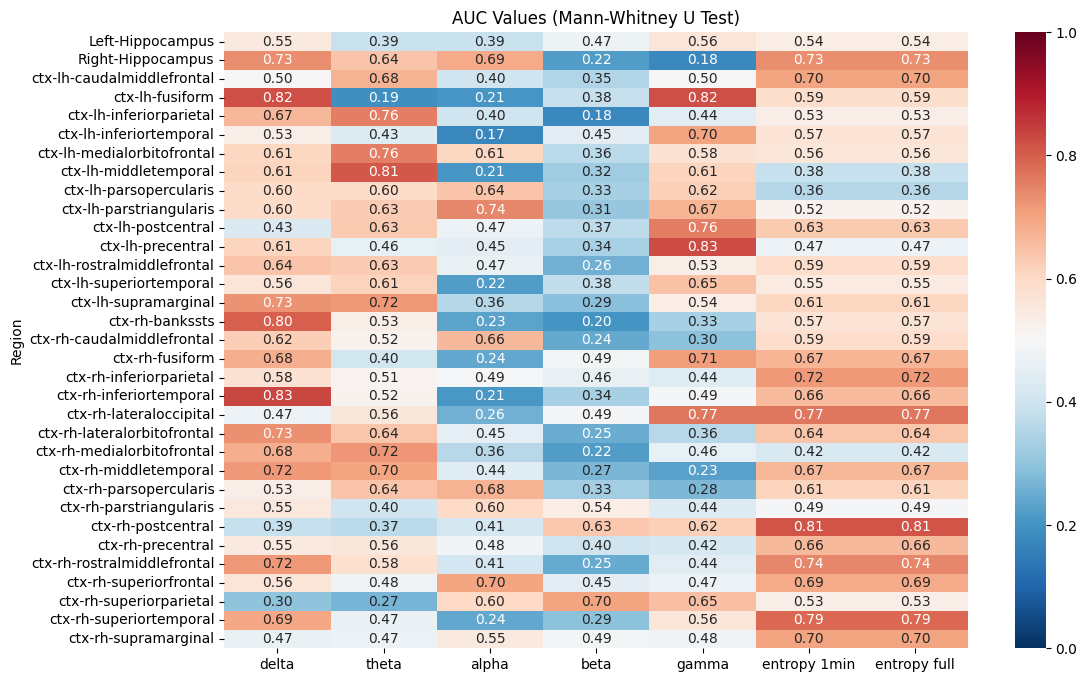

In [53]:
def compute_mann_whitney_stats(group1: np.ndarray, 
                             group2: np.ndarray) -> Tuple[float, float, float]:
    """
    Compute Mann-Whitney U statistic and derive AUC.
    
    Parameters:
    -----------
    group1, group2 : np.ndarray
        Arrays containing measurements for each group
        
    Returns:
    --------
    Tuple[float, float, float]
        (U statistic, AUC, p-value)
    """
    stat, p_value = stats.mannwhitneyu(group1, group2, alternative='two-sided')
    n1, n2 = len(group1), len(group2)
    
    # Convert U statistic to AUC
    auc = stat / (n1 * n2)
    
    return stat, auc, p_value

def analyze_effect_sizes_mw(hup_features: pd.DataFrame, 
                          mni_features: pd.DataFrame, 
                          min_patients: int = 5) -> Dict:
    """
    Compute Mann-Whitney U statistics and AUC for all region-feature pairs.
    
    Parameters:
    -----------
    hup_features, mni_features : pd.DataFrame
        DataFrames containing features for each cohort
    min_patients : int
        Minimum number of patients required for analysis
        
    Returns:
    --------
    Dict
        Nested dictionary containing test results
    """
    feature_columns = [
        'deltaRel_mean', 'thetaRel_mean', 'alphaRel_mean', 'betaRel_mean',
        'gammaRel_mean', 'entropy_1min_mean', 'entropy_fullts_mean'
    ]
    
    common_regions = set(hup_features['roi'].unique()) & set(mni_features['roi'].unique())
    
    results = {}
    
    for region in common_regions:
        # Get patient counts
        hup_patients = hup_features[hup_features['roi'] == region]['patient_id'].nunique()
        mni_patients = mni_features[mni_features['roi'] == region]['patient_id'].nunique()
        
        if hup_patients < min_patients or mni_patients < min_patients:
            continue
            
        results[region] = {}
        
        for feature in feature_columns:
            hup_data = hup_features[hup_features['roi'] == region][feature].values
            mni_data = mni_features[mni_features['roi'] == region][feature].values
            
            # Compute statistics
            u_stat, auc, p_value = compute_mann_whitney_stats(hup_data, mni_data)
            
            results[region][feature] = {
                'U_statistic': u_stat,
                'AUC': auc,
                'p_value': p_value,
                'hup_n': len(hup_data),
                'mni_n': len(mni_data)
            }
    
    return results

def visualize_mw_results(results: Dict):
    """
    Create visualizations for Mann-Whitney test results.
    """
    # Define feature order and mapping
    feature_order = [
        'deltaRel_mean', 
        'thetaRel_mean', 
        'alphaRel_mean', 
        'betaRel_mean',
        'gammaRel_mean', 
        'entropy_1min_mean', 
        'entropy_fullts_mean'
    ]
    
    feature_name_mapping = {
        'deltaRel_mean': 'delta',
        'thetaRel_mean': 'theta', 
        'alphaRel_mean': 'alpha',
        'betaRel_mean': 'beta',
        'gammaRel_mean': 'gamma',
        'entropy_1min_mean': 'entropy 1min',
        'entropy_fullts_mean': 'entropy full'
    }
    
    # Convert results to DataFrame
    df_list = []
    for region in results:
        for feature in results[region]:
            res = results[region][feature]
            df_list.append({
                'Region': region,
                'Feature': feature,
                'AUC': res['AUC'],
                'p_value': res['p_value']
            })
    
    df = pd.DataFrame(df_list)
    
    # 1. Heatmap of AUC values
    plt.figure(figsize=(12, 8))
    heatmap_data = df.pivot(index='Region', columns='Feature', values='AUC')
    # Reorder columns according to feature_order
    heatmap_data = heatmap_data[feature_order]
    # Rename columns with simplified names
    heatmap_data.columns = [feature_name_mapping[col] for col in heatmap_data.columns]
    
    sns.heatmap(heatmap_data, cmap='RdBu_r', center=0.5,
                vmin=0, vmax=1, annot=True, fmt='.2f')
    plt.title('AUC Values (Mann-Whitney U Test)')
    # Rotate x-axis labels to horizontal
    plt.xticks(rotation=0)
    # plt.tight_layout()
    # plt.show()
    
    # Print summary statistics
    print("\nEffect Size Summary:")
    print("=" * 50)
    
    # Count effects by size
    large_effects = df[abs(df['AUC'] - 0.5) >= 0.21].shape[0]  # |AUC - 0.5| ≥ 0.21 for large effect
    medium_effects = df[(abs(df['AUC'] - 0.5) >= 0.14) & 
                       (abs(df['AUC'] - 0.5) < 0.21)].shape[0]
    small_effects = df[(abs(df['AUC'] - 0.5) >= 0.06) & 
                      (abs(df['AUC'] - 0.5) < 0.14)].shape[0]
    
    print(f"\nLarge effects (|AUC - 0.5| ≥ 0.21): {large_effects}")
    print(f"Medium effects (0.14 ≤ |AUC - 0.5| < 0.21): {medium_effects}")
    print(f"Small effects (0.06 ≤ |AUC - 0.5| < 0.14): {small_effects}")
    
    # Print top effects
    print("\nTop 5 Largest Effects:")
    df['effect_size'] = abs(df['AUC'] - 0.5)
    top_effects = df.nlargest(5, 'effect_size')
    for _, row in top_effects.iterrows():
        direction = "HUP > MNI" if row['AUC'] > 0.5 else "MNI > HUP"
        print(f"{row['Region']} - {row['Feature']}: "
              f"AUC = {row['AUC']:.3f} ({direction}), "
              f"p = {row['p_value']:.4f}")

def main():
    """
    Main function to run the Mann-Whitney analysis.
    """
    # Load data
    hup_region_features = pd.read_csv(os.path.join(base_path_results, 'ge_go_hup_region_features.csv'))
    mni_region_features = pd.read_csv(os.path.join(base_path_results, 'mni_region_features.csv'))
    
    # Run analysis
    results = analyze_effect_sizes_mw(
        hup_region_features,
        mni_region_features,
        min_patients=5
    )
    
    # Visualize results
    visualize_mw_results(results)

if __name__ == "__main__":
    main()

Includes correction for multiple comparisons

In [52]:
# def compute_mann_whitney_stats(group1: np.ndarray, 
#                              group2: np.ndarray) -> Tuple[float, float, float]:
#     """
#     Compute Mann-Whitney U statistic and derive AUC.
    
#     Parameters:
#     -----------
#     group1, group2 : np.ndarray
#         Arrays containing measurements for each group
        
#     Returns:
#     --------
#     Tuple[float, float, float]
#         (U statistic, AUC, p-value)
#     """
#     stat, p_value = stats.mannwhitneyu(group1, group2, alternative='two-sided')
#     n1, n2 = len(group1), len(group2)
    
#     # Convert U statistic to AUC
#     auc = stat / (n1 * n2)
    
#     return stat, auc, p_value

# def analyze_effect_sizes_mw(hup_features: pd.DataFrame, 
#                           mni_features: pd.DataFrame, 
#                           min_patients: int = 5) -> Dict:
#     """
#     Compute Mann-Whitney U statistics and AUC for all region-feature pairs.
#     Includes multiple comparison corrections.
#     """
#     feature_columns = [
#         'deltaRel_mean', 'thetaRel_mean', 'alphaRel_mean', 'betaRel_mean',
#         'gammaRel_mean', 'entropy_1min_mean', 'entropy_fullts_mean'
#     ]
    
#     common_regions = set(hup_features['roi'].unique()) & set(mni_features['roi'].unique())
    
#     results = {}
#     all_p_values = []  # Store all p-values for multiple comparison correction
#     region_feature_pairs = []  # Store corresponding region-feature pairs
    
#     for region in common_regions:
#         # Get patient counts
#         hup_patients = hup_features[hup_features['roi'] == region]['patient_id'].nunique()
#         mni_patients = mni_features[mni_features['roi'] == region]['patient_id'].nunique()
        
#         if hup_patients < min_patients or mni_patients < min_patients:
#             continue
            
#         results[region] = {}
        
#         for feature in feature_columns:
#             hup_data = hup_features[hup_features['roi'] == region][feature].values
#             mni_data = mni_features[mni_features['roi'] == region][feature].values
            
#             # Compute statistics
#             u_stat, auc, p_value = compute_mann_whitney_stats(hup_data, mni_data)
            
#             # Store p-value and pair for correction
#             all_p_values.append(p_value)
#             region_feature_pairs.append((region, feature))
            
#             results[region][feature] = {
#                 'U_statistic': u_stat,
#                 'AUC': auc,
#                 'p_value': p_value,
#                 'hup_n': len(hup_data),
#                 'mni_n': len(mni_data)
#             }
    
#     # Perform multiple comparison corrections
#     all_p_values = np.array(all_p_values)
    
#     # Bonferroni correction
#     bonferroni_threshold = 0.05 / len(all_p_values)
#     bonferroni_significant = all_p_values < bonferroni_threshold
    
#     # FDR correction (Benjamini-Hochberg)
#     from statsmodels.stats.multitest import multipletests
#     _, p_values_fdr, _, _ = multipletests(all_p_values, method='fdr_bh')
    
#     # Add correction results to the dictionary
#     for (region, feature), p_orig, p_fdr, is_bonf_sig in zip(
#             region_feature_pairs, all_p_values, p_values_fdr, bonferroni_significant):
#         results[region][feature].update({
#             'p_value_bonferroni_threshold': bonferroni_threshold,
#             'significant_bonferroni': is_bonf_sig,
#             'p_value_fdr': p_fdr,
#             'significant_fdr': p_fdr < 0.05
#         })
    
#     return results

# def visualize_mw_results(results: Dict):
#     """
#     Create visualizations for Mann-Whitney test results with multiple comparison corrections.
#     """
#     # Define feature order and mapping
#     feature_order = [
#         'deltaRel_mean', 
#         'thetaRel_mean', 
#         'alphaRel_mean', 
#         'betaRel_mean',
#         'gammaRel_mean', 
#         'entropy_1min_mean', 
#         'entropy_fullts_mean'
#     ]
    
#     feature_name_mapping = {
#         'deltaRel_mean': 'delta',
#         'thetaRel_mean': 'theta', 
#         'alphaRel_mean': 'alpha',
#         'betaRel_mean': 'beta',
#         'gammaRel_mean': 'gamma',
#         'entropy_1min_mean': 'entropy 1min',
#         'entropy_fullts_mean': 'entropy full'
#     }
    
#     # Convert results to DataFrame
#     df_list = []
#     for region in results:
#         for feature in results[region]:
#             res = results[region][feature]
#             df_list.append({
#                 'Region': region,
#                 'Feature': feature,
#                 'AUC': res['AUC'],
#                 'p_value': res['p_value'],
#                 'p_value_fdr': res['p_value_fdr'],
#                 'significant_bonferroni': res['significant_bonferroni'],
#                 'significant_fdr': res['significant_fdr']
#             })
    
#     df = pd.DataFrame(df_list)
    
#     # 1. Heatmap of AUC values
#     plt.figure(figsize=(12, 8))
#     heatmap_data = df.pivot(index='Region', columns='Feature', values='AUC')
#     heatmap_data = heatmap_data[feature_order]
#     heatmap_data.columns = [feature_name_mapping[col] for col in heatmap_data.columns]
    
#     sns.heatmap(heatmap_data, cmap='RdBu_r', center=0.5,
#                 vmin=0, vmax=1, annot=True, fmt='.2f')
#     plt.title('AUC Values (Mann-Whitney U Test)')
#     plt.xticks(rotation=0)
#     plt.tight_layout()
#     plt.show()
    
#     # Compute effect magnitudes
#     df['effect_magnitude'] = abs(df['AUC'] - 0.5)
    
#     # Print significance analysis
#     print("\nSignificance Analysis:")
#     print("=" * 50)
#     n_tests = len(df)
#     n_uncorrected = df[df['p_value'] < 0.05].shape[0]
#     n_fdr = df[df['significant_fdr']].shape[0]
#     n_bonf = df[df['significant_bonferroni']].shape[0]
    
#     print(f"\nTotal tests performed: {n_tests}")
#     print(f"Significant before correction (p < 0.05): {n_uncorrected}")
#     print(f"Significant after FDR correction: {n_fdr}")
#     print(f"Significant after Bonferroni correction: {n_bonf}")
    
#     # Print top effects with corrections
#     print("\nTop 5 Largest Effects with Multiple Comparison Corrections:")
#     print("=" * 50)
#     top_effects = df.nlargest(5, 'effect_magnitude')
#     for _, row in top_effects.iterrows():
#         region, feature = row['Region'], row['Feature']
#         direction = "HUP > MNI" if row['AUC'] > 0.5 else "MNI > HUP"
#         print(f"\n{region} - {feature}:")
#         print(f"  AUC = {row['AUC']:.3f} ({direction})")
#         print(f"  Original p = {row['p_value']:.4f}")
#         print(f"  FDR-corrected p = {row['p_value_fdr']:.4f}")
        
#         # Print significance levels
#         significance = []
#         if row['significant_bonferroni']:
#             significance.append("Significant after Bonferroni")
#         elif row['significant_fdr']:
#             significance.append("Significant after FDR")
#         elif row['p_value'] < 0.05:
#             significance.append("Only significant before correction")
#         else:
#             significance.append("Not significant")
#         print(f"  Significance: {significance[0]}")

#     # Print summary by effect size
#     print("\nEffect Size Distribution:")
#     print("=" * 50)
#     large = df[df['effect_magnitude'] >= 0.21].shape[0]
#     medium = df[(df['effect_magnitude'] >= 0.14) & (df['effect_magnitude'] < 0.21)].shape[0]
#     small = df[(df['effect_magnitude'] >= 0.06) & (df['effect_magnitude'] < 0.14)].shape[0]
    
#     print(f"\nLarge effects (|AUC - 0.5| ≥ 0.21): {large}")
#     print(f"Medium effects (0.14 ≤ |AUC - 0.5| < 0.21): {medium}")
#     print(f"Small effects (0.06 ≤ |AUC - 0.5| < 0.14): {small}")
    
#     # Print significant effects after correction
#     print("\nSignificant Effects After Correction:")
#     print("=" * 50)
#     sig_after_correction = df[df['significant_fdr']].sort_values('effect_magnitude', ascending=False)
    
#     if len(sig_after_correction) > 0:
#         print("\nTop significant effects after FDR correction:")
#         for _, row in sig_after_correction.head().iterrows():
#             direction = "HUP > MNI" if row['AUC'] > 0.5 else "MNI > HUP"
#             print(f"\n{row['Region']} - {feature_name_mapping[row['Feature']]}:")
#             print(f"  AUC = {row['AUC']:.3f} ({direction})")
#             print(f"  FDR-corrected p = {row['p_value_fdr']:.4f}")
#     # [previous visualization code remains the same]
    
#     # Print summary statistics with multiple comparison corrections
#     print("\nMultiple Comparison Correction Summary:")
#     print("=" * 50)
    
#     # Count significant results
#     n_total = sum(len(results[region]) for region in results)
#     n_sig_uncorrected = sum(
#         1 for region in results for feature in results[region]
#         if results[region][feature]['p_value'] < 0.05
#     )
#     n_sig_bonferroni = sum(
#         1 for region in results for feature in results[region]
#         if results[region][feature]['significant_bonferroni']
#     )
#     n_sig_fdr = sum(
#         1 for region in results for feature in results[region]
#         if results[region][feature]['significant_fdr']
#     )
    
#     print(f"\nTotal number of tests: {n_total}")
#     print(f"Significant results (uncorrected p < 0.05): {n_sig_uncorrected}")
#     print(f"Significant results (Bonferroni corrected): {n_sig_bonferroni}")
#     print(f"Significant results (FDR corrected): {n_sig_fdr}")
    
#     # Print top effects with corrected p-values
#     print("\nTop 5 Largest Effects (with corrections):")
#     df['effect_size'] = abs(df['AUC'] - 0.5)
#     top_effects = df.nlargest(5, 'effect_size')
#     for _, row in top_effects.iterrows():
#         region, feature = row['Region'], row['Feature']
#         result = results[region][feature]
#         direction = "HUP > MNI" if row['AUC'] > 0.5 else "MNI > HUP"
#         print(f"\n{region} - {feature}:")
#         print(f"  AUC = {row['AUC']:.3f} ({direction})")
#         print(f"  Original p = {result['p_value']:.4f}")
#         print(f"  FDR-corrected p = {result['p_value_fdr']:.4f}")
#         print(f"  Significant after Bonferroni: {'Yes' if result['significant_bonferroni'] else 'No'}")
#         print(f"  Significant after FDR: {'Yes' if result['significant_fdr'] else 'No'}")

# def visualize_mw_results(results: Dict):
#     """
#     Create visualizations for Mann-Whitney test results with multiple comparison corrections
#     and generate detailed summaries of significant results.
#     """
#     # Define feature order and mapping
#     feature_order = [
#         'deltaRel_mean', 
#         'thetaRel_mean', 
#         'alphaRel_mean', 
#         'betaRel_mean',
#         'gammaRel_mean', 
#         'entropy_1min_mean', 
#         'entropy_fullts_mean'
#     ]
    
#     feature_name_mapping = {
#         'deltaRel_mean': 'delta',
#         'thetaRel_mean': 'theta', 
#         'alphaRel_mean': 'alpha',
#         'betaRel_mean': 'beta',
#         'gammaRel_mean': 'gamma',
#         'entropy_1min_mean': 'entropy 1min',
#         'entropy_fullts_mean': 'entropy full'
#     }
    
#     # Convert results to DataFrame
#     df_list = []
#     for region in results:
#         for feature in results[region]:
#             res = results[region][feature]
#             df_list.append({
#                 'Region': region,
#                 'Feature': feature,
#                 'AUC': res['AUC'],
#                 'p_value': res['p_value'],
#                 'p_value_fdr': res['p_value_fdr'],
#                 'significant_bonferroni': res['significant_bonferroni'],
#                 'significant_fdr': res['significant_fdr']
#             })
    
#     df = pd.DataFrame(df_list)
    
#     # 1. Heatmap of AUC values
#     plt.figure(figsize=(12, 8))
#     heatmap_data = df.pivot(index='Region', columns='Feature', values='AUC')
#     heatmap_data = heatmap_data[feature_order]
#     heatmap_data.columns = [feature_name_mapping[col] for col in heatmap_data.columns]
    
#     sns.heatmap(heatmap_data, cmap='RdBu_r', center=0.5,
#                 vmin=0, vmax=1, annot=True, fmt='.2f')
#     plt.title('AUC Values (Mann-Whitney U Test)')
#     plt.xticks(rotation=0)
#     plt.tight_layout()
#     plt.show()
    
#     # Compute effect magnitudes
#     df['effect_magnitude'] = abs(df['AUC'] - 0.5)
    
#     # Print significance analysis
#     print("\nSignificance Analysis:")
#     print("=" * 50)
#     n_tests = len(df)
#     n_uncorrected = df[df['p_value'] < 0.05].shape[0]
#     n_fdr = df[df['significant_fdr']].shape[0]
#     n_bonf = df[df['significant_bonferroni']].shape[0]
    
#     print(f"\nTotal tests performed: {n_tests}")
#     print(f"Significant before correction (p < 0.05): {n_uncorrected}")
#     print(f"Significant after FDR correction: {n_fdr}")
#     print(f"Significant after Bonferroni correction: {n_bonf}")
    
#     # Detailed breakdown of significant results by region and feature
#     sig_fdr = df[df['significant_fdr']]
#     sig_bonf = df[df['significant_bonferroni']]
    
#     print("\nDetailed Significant Results (FDR Correction):")
#     print("=" * 50)
#     for _, row in sig_fdr.iterrows():
#         direction = "HUP > MNI" if row['AUC'] > 0.5 else "MNI > HUP"
#         print(f"{row['Region']} - {feature_name_mapping[row['Feature']]}:")
#         print(f"  AUC = {row['AUC']:.3f} ({direction})")
#         print(f"  Raw p = {row['p_value']:.4f}, FDR-corrected p = {row['p_value_fdr']:.4f}")

#     print("\nDetailed Significant Results (Bonferroni Correction):")
#     print("=" * 50)
#     for _, row in sig_bonf.iterrows():
#         direction = "HUP > MNI" if row['AUC'] > 0.5 else "MNI > HUP"
#         print(f"{row['Region']} - {feature_name_mapping[row['Feature']]}:")
#         print(f"  AUC = {row['AUC']:.3f} ({direction})")
#         print(f"  Raw p = {row['p_value']:.4f}, Bonferroni threshold = {row['p_value_fdr']:.4f}")
    
#     # Print summary by effect size
#     print("\nEffect Size Distribution:")
#     print("=" * 50)
#     large = df[df['effect_magnitude'] >= 0.21].shape[0]
#     medium = df[(df['effect_magnitude'] >= 0.14) & (df['effect_magnitude'] < 0.21)].shape[0]
#     small = df[(df['effect_magnitude'] >= 0.06) & (df['effect_magnitude'] < 0.14)].shape[0]
    
#     print(f"\nLarge effects (|AUC - 0.5| ≥ 0.21): {large}")
#     print(f"Medium effects (0.14 ≤ |AUC - 0.5| < 0.21): {medium}")
#     print(f"Small effects (0.06 ≤ |AUC - 0.5| < 0.14): {small}")
    
#     # Print proportion of regions/features with significant effects
#     total_features = len(feature_order)
#     total_regions = df['Region'].nunique()
#     print(f"\nProportion of Regions with Significant Effects:")
#     print(f"FDR Correction: {sig_fdr['Region'].nunique()}/{total_regions} regions")
#     print(f"Bonferroni Correction: {sig_bonf['Region'].nunique()}/{total_regions} regions")


# def main():
#     """
#     Main function to run the Mann-Whitney analysis.
#     """
#     # Load data
#     hup_region_features = pd.read_csv(os.path.join(base_path_results, 'ge_go_hup_region_features.csv'))
#     mni_region_features = pd.read_csv(os.path.join(base_path_results, 'mni_region_features.csv'))
    
#     # Run analysis
#     results = analyze_effect_sizes_mw(
#         hup_region_features,
#         mni_region_features,
#         min_patients=5
#     )
    
#     # Visualize results
#     visualize_mw_results(results)

# if __name__ == "__main__":
#     main()

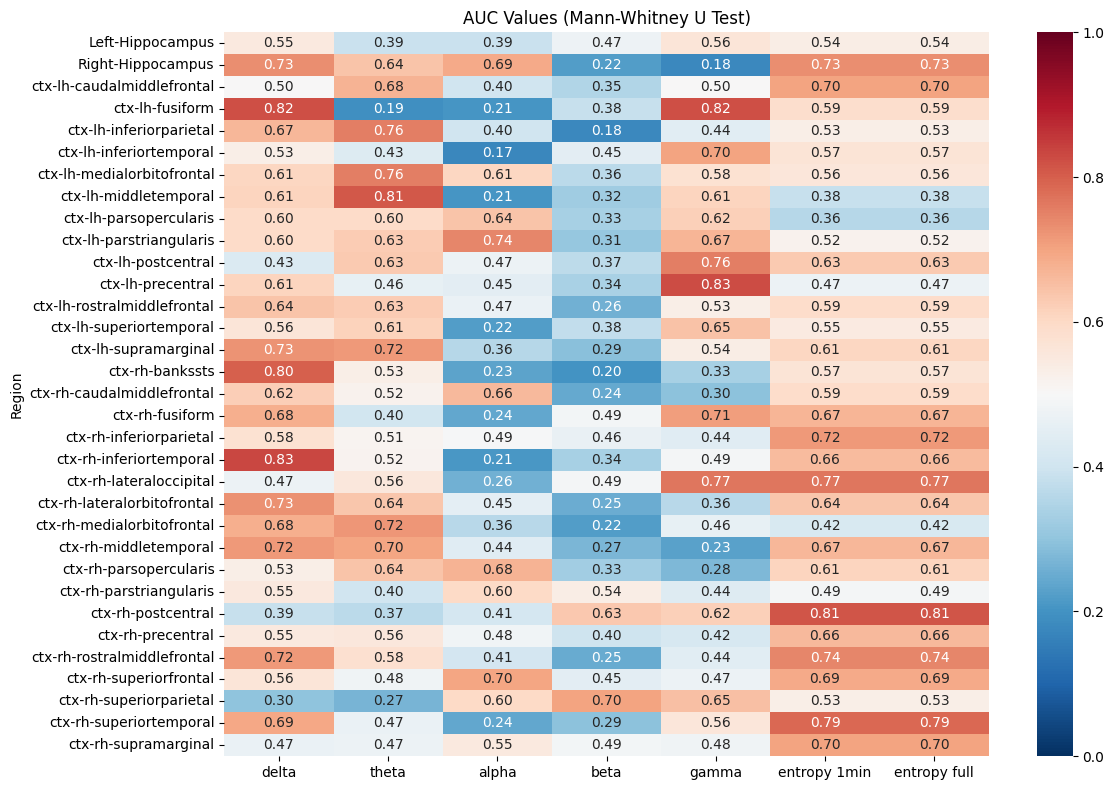


Effect Size Summary:

Large effects (|AUC - 0.5| ≥ 0.21): 53
Medium effects (0.14 ≤ |AUC - 0.5| < 0.21): 54
Small effects (0.06 ≤ |AUC - 0.5| < 0.14): 67

Top 5 Largest Effects:
ctx-rh-inferiortemporal - deltaRel_mean: AUC = 0.832 (HUP > MNI), p = 0.0065
ctx-lh-precentral - gammaRel_mean: AUC = 0.827 (HUP > MNI), p = 0.0159
ctx-lh-inferiortemporal - alphaRel_mean: AUC = 0.174 (MNI > HUP), p = 0.0037
ctx-lh-inferiorparietal - betaRel_mean: AUC = 0.178 (MNI > HUP), p = 0.0599
Right-Hippocampus - gammaRel_mean: AUC = 0.178 (MNI > HUP), p = 0.0599


In [54]:
# include saving step 

def compute_mann_whitney_stats(group1: np.ndarray, 
                             group2: np.ndarray) -> Tuple[float, float, float]:
    """
    Compute Mann-Whitney U statistic and derive AUC.
    
    Parameters:
    -----------
    group1, group2 : np.ndarray
        Arrays containing measurements for each group
        
    Returns:
    --------
    Tuple[float, float, float]
        (U statistic, AUC, p-value)
    """
    stat, p_value = stats.mannwhitneyu(group1, group2, alternative='two-sided')
    n1, n2 = len(group1), len(group2)
    
    # Convert U statistic to AUC
    auc = stat / (n1 * n2)
    
    return stat, auc, p_value

def analyze_effect_sizes_mw(hup_features: pd.DataFrame, 
                          mni_features: pd.DataFrame, 
                          min_patients: int = 5) -> Dict:
    """
    Compute Mann-Whitney U statistics and AUC for all region-feature pairs.
    Includes multiple comparison corrections.
    """
    feature_columns = [
        'deltaRel_mean', 'thetaRel_mean', 'alphaRel_mean', 'betaRel_mean',
        'gammaRel_mean', 'entropy_1min_mean', 'entropy_fullts_mean'
    ]
    
    common_regions = set(hup_features['roi'].unique()) & set(mni_features['roi'].unique())
    
    results = {}
    all_p_values = []  # Store all p-values for multiple comparison correction
    region_feature_pairs = []  # Store corresponding region-feature pairs
    
    for region in common_regions:
        # Get patient counts
        hup_patients = hup_features[hup_features['roi'] == region]['patient_id'].nunique()
        mni_patients = mni_features[mni_features['roi'] == region]['patient_id'].nunique()
        
        if hup_patients < min_patients or mni_patients < min_patients:
            continue
            
        results[region] = {}
        
        for feature in feature_columns:
            hup_data = hup_features[hup_features['roi'] == region][feature].values
            mni_data = mni_features[mni_features['roi'] == region][feature].values
            
            # Compute statistics
            u_stat, auc, p_value = compute_mann_whitney_stats(hup_data, mni_data)
            
            # Store p-value and pair for correction
            all_p_values.append(p_value)
            region_feature_pairs.append((region, feature))
            
            results[region][feature] = {
                'U_statistic': u_stat,
                'AUC': auc,
                'p_value': p_value,
                'hup_n': len(hup_data),
                'mni_n': len(mni_data)
            }
    
    # Perform multiple comparison corrections
    all_p_values = np.array(all_p_values)
    
    # Bonferroni correction
    bonferroni_threshold = 0.05 / len(all_p_values)
    bonferroni_significant = all_p_values < bonferroni_threshold
    
    # FDR correction (Benjamini-Hochberg)
    from statsmodels.stats.multitest import multipletests
    _, p_values_fdr, _, _ = multipletests(all_p_values, method='fdr_bh')
    
    # Add correction results to the dictionary
    for (region, feature), p_orig, p_fdr, is_bonf_sig in zip(
            region_feature_pairs, all_p_values, p_values_fdr, bonferroni_significant):
        results[region][feature].update({
            'p_value_bonferroni_threshold': bonferroni_threshold,
            'significant_bonferroni': is_bonf_sig,
            'p_value_fdr': p_fdr,
            'significant_fdr': p_fdr < 0.05
        })
    
    return results

def visualize_mw_results(results: Dict):
    """
    Create visualizations for Mann-Whitney test results with multiple comparison corrections.
    """
    # Define feature order and mapping
    feature_order = [
        'deltaRel_mean', 
        'thetaRel_mean', 
        'alphaRel_mean', 
        'betaRel_mean',
        'gammaRel_mean', 
        'entropy_1min_mean', 
        'entropy_fullts_mean'
    ]
    
    feature_name_mapping = {
        'deltaRel_mean': 'delta',
        'thetaRel_mean': 'theta', 
        'alphaRel_mean': 'alpha',
        'betaRel_mean': 'beta',
        'gammaRel_mean': 'gamma',
        'entropy_1min_mean': 'entropy 1min',
        'entropy_fullts_mean': 'entropy full'
    }
    
    # Convert results to DataFrame
    df_list = []
    for region in results:
        for feature in results[region]:
            res = results[region][feature]
            df_list.append({
                'Region': region,
                'Feature': feature,
                'AUC': res['AUC'],
                'p_value': res['p_value'],
                'p_value_fdr': res['p_value_fdr'],
                'significant_bonferroni': res['significant_bonferroni'],
                'significant_fdr': res['significant_fdr']
            })
    
    df = pd.DataFrame(df_list)
    
    # 1. Heatmap of AUC values
    plt.figure(figsize=(12, 8))
    heatmap_data = df.pivot(index='Region', columns='Feature', values='AUC')
    heatmap_data = heatmap_data[feature_order]
    heatmap_data.columns = [feature_name_mapping[col] for col in heatmap_data.columns]
    
    sns.heatmap(heatmap_data, cmap='RdBu_r', center=0.5,
                vmin=0, vmax=1, annot=True, fmt='.2f')
    plt.title('AUC Values (Mann-Whitney U Test)')
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    # Compute effect magnitudes
    df['effect_magnitude'] = abs(df['AUC'] - 0.5)
    
    # Print significance analysis
    print("\nSignificance Analysis:")
    print("=" * 50)
    n_tests = len(df)
    n_uncorrected = df[df['p_value'] < 0.05].shape[0]
    n_fdr = df[df['significant_fdr']].shape[0]
    n_bonf = df[df['significant_bonferroni']].shape[0]
    
    print(f"\nTotal tests performed: {n_tests}")
    print(f"Significant before correction (p < 0.05): {n_uncorrected}")
    print(f"Significant after FDR correction: {n_fdr}")
    print(f"Significant after Bonferroni correction: {n_bonf}")
    
    # Print top effects with corrections
    print("\nTop 5 Largest Effects with Multiple Comparison Corrections:")
    print("=" * 50)
    top_effects = df.nlargest(5, 'effect_magnitude')
    for _, row in top_effects.iterrows():
        region, feature = row['Region'], row['Feature']
        direction = "HUP > MNI" if row['AUC'] > 0.5 else "MNI > HUP"
        print(f"\n{region} - {feature}:")
        print(f"  AUC = {row['AUC']:.3f} ({direction})")
        print(f"  Original p = {row['p_value']:.4f}")
        print(f"  FDR-corrected p = {row['p_value_fdr']:.4f}")
        
        # Print significance levels
        significance = []
        if row['significant_bonferroni']:
            significance.append("Significant after Bonferroni")
        elif row['significant_fdr']:
            significance.append("Significant after FDR")
        elif row['p_value'] < 0.05:
            significance.append("Only significant before correction")
        else:
            significance.append("Not significant")
        print(f"  Significance: {significance[0]}")

    # Print summary by effect size
    print("\nEffect Size Distribution:")
    print("=" * 50)
    large = df[df['effect_magnitude'] >= 0.21].shape[0]
    medium = df[(df['effect_magnitude'] >= 0.14) & (df['effect_magnitude'] < 0.21)].shape[0]
    small = df[(df['effect_magnitude'] >= 0.06) & (df['effect_magnitude'] < 0.14)].shape[0]
    
    print(f"\nLarge effects (|AUC - 0.5| ≥ 0.21): {large}")
    print(f"Medium effects (0.14 ≤ |AUC - 0.5| < 0.21): {medium}")
    print(f"Small effects (0.06 ≤ |AUC - 0.5| < 0.14): {small}")
    
    # Print significant effects after correction
    print("\nSignificant Effects After Correction:")
    print("=" * 50)
    sig_after_correction = df[df['significant_fdr']].sort_values('effect_magnitude', ascending=False)
    
    if len(sig_after_correction) > 0:
        print("\nTop significant effects after FDR correction:")
        for _, row in sig_after_correction.head().iterrows():
            direction = "HUP > MNI" if row['AUC'] > 0.5 else "MNI > HUP"
            print(f"\n{row['Region']} - {feature_name_mapping[row['Feature']]}:")
            print(f"  AUC = {row['AUC']:.3f} ({direction})")
            print(f"  FDR-corrected p = {row['p_value_fdr']:.4f}")
    # [previous visualization code remains the same]
    
    # Print summary statistics with multiple comparison corrections
    print("\nMultiple Comparison Correction Summary:")
    print("=" * 50)
    
    # Count significant results
    n_total = sum(len(results[region]) for region in results)
    n_sig_uncorrected = sum(
        1 for region in results for feature in results[region]
        if results[region][feature]['p_value'] < 0.05
    )
    n_sig_bonferroni = sum(
        1 for region in results for feature in results[region]
        if results[region][feature]['significant_bonferroni']
    )
    n_sig_fdr = sum(
        1 for region in results for feature in results[region]
        if results[region][feature]['significant_fdr']
    )
    
    print(f"\nTotal number of tests: {n_total}")
    print(f"Significant results (uncorrected p < 0.05): {n_sig_uncorrected}")
    print(f"Significant results (Bonferroni corrected): {n_sig_bonferroni}")
    print(f"Significant results (FDR corrected): {n_sig_fdr}")
    
    # Print top effects with corrected p-values
    print("\nTop 5 Largest Effects (with corrections):")
    df['effect_size'] = abs(df['AUC'] - 0.5)
    top_effects = df.nlargest(5, 'effect_size')
    for _, row in top_effects.iterrows():
        region, feature = row['Region'], row['Feature']
        result = results[region][feature]
        direction = "HUP > MNI" if row['AUC'] > 0.5 else "MNI > HUP"
        print(f"\n{region} - {feature}:")
        print(f"  AUC = {row['AUC']:.3f} ({direction})")
        print(f"  Original p = {result['p_value']:.4f}")
        print(f"  FDR-corrected p = {result['p_value_fdr']:.4f}")
        print(f"  Significant after Bonferroni: {'Yes' if result['significant_bonferroni'] else 'No'}")
        print(f"  Significant after FDR: {'Yes' if result['significant_fdr'] else 'No'}")


def visualize_mw_results(results: Dict):
    """
    Create visualizations for Mann-Whitney test results.
    """
    # Define feature order and mapping
    feature_order = [
        'deltaRel_mean', 
        'thetaRel_mean', 
        'alphaRel_mean', 
        'betaRel_mean',
        'gammaRel_mean', 
        'entropy_1min_mean', 
        'entropy_fullts_mean'
    ]
    
    feature_name_mapping = {
        'deltaRel_mean': 'delta',
        'thetaRel_mean': 'theta', 
        'alphaRel_mean': 'alpha',
        'betaRel_mean': 'beta',
        'gammaRel_mean': 'gamma',
        'entropy_1min_mean': 'entropy 1min',
        'entropy_fullts_mean': 'entropy full'
    }
    
    # Convert results to DataFrame
    df_list = []
    for region in results:
        for feature in results[region]:
            res = results[region][feature]
            df_list.append({
                'Region': region,
                'Feature': feature,
                'AUC': res['AUC'],
                'p_value': res['p_value']
            })
    
    df = pd.DataFrame(df_list)
    
    # 1. Heatmap of AUC values
    plt.figure(figsize=(12, 8))
    heatmap_data = df.pivot(index='Region', columns='Feature', values='AUC')
    # Reorder columns according to feature_order
    heatmap_data = heatmap_data[feature_order]
    # Rename columns with simplified names
    heatmap_data.columns = [feature_name_mapping[col] for col in heatmap_data.columns]
    
    sns.heatmap(heatmap_data, cmap='RdBu_r', center=0.5,
                vmin=0, vmax=1, annot=True, fmt='.2f')
    plt.title('AUC Values (Mann-Whitney U Test)')
    # Rotate x-axis labels to horizontal
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\nEffect Size Summary:")
    print("=" * 50)
    
    # Count effects by size
    large_effects = df[abs(df['AUC'] - 0.5) >= 0.21].shape[0]  # |AUC - 0.5| ≥ 0.21 for large effect
    medium_effects = df[(abs(df['AUC'] - 0.5) >= 0.14) & 
                       (abs(df['AUC'] - 0.5) < 0.21)].shape[0]
    small_effects = df[(abs(df['AUC'] - 0.5) >= 0.06) & 
                      (abs(df['AUC'] - 0.5) < 0.14)].shape[0]
    
    print(f"\nLarge effects (|AUC - 0.5| ≥ 0.21): {large_effects}")
    print(f"Medium effects (0.14 ≤ |AUC - 0.5| < 0.21): {medium_effects}")
    print(f"Small effects (0.06 ≤ |AUC - 0.5| < 0.14): {small_effects}")
    
    # Print top effects
    print("\nTop 5 Largest Effects:")
    df['effect_size'] = abs(df['AUC'] - 0.5)
    top_effects = df.nlargest(5, 'effect_size')
    for _, row in top_effects.iterrows():
        direction = "HUP > MNI" if row['AUC'] > 0.5 else "MNI > HUP"
        print(f"{row['Region']} - {row['Feature']}: "
              f"AUC = {row['AUC']:.3f} ({direction}), "
              f"p = {row['p_value']:.4f}")

def main():
    """
    Main function to run the Mann-Whitney analysis.
    """
    # Load data
    hup_region_features = pd.read_csv(os.path.join(base_path_results, 'ge_go_hup_region_features.csv'))
    mni_region_features = pd.read_csv(os.path.join(base_path_results, 'mni_region_features.csv'))
    
    # Run analysis
    results = analyze_effect_sizes_mw(
        hup_region_features,
        mni_region_features,
        min_patients=5
    )
    
    # Save results dictionary
    with open(os.path.join(base_path_results, 'mann_whitney_results.pkl'), 'wb') as f:
        pickle.dump(results, f)
    
    # Also save as a more readable format for inspection
    # Convert nested dictionary to DataFrame
    results_df = []
    for region in results:
        for feature in results[region]:
            result = results[region][feature]
            results_df.append({
                'Region': region,
                'Feature': feature,
                **result  # Unpack all statistics
            })
    
    results_df = pd.DataFrame(results_df)
    results_df.to_csv(os.path.join(base_path_results, 'mann_whitney_results.csv'), index=False)
    
    # Visualize results
    visualize_mw_results(results)

if __name__ == "__main__":
    main()

In [ ]:
def inspect_results(base_path_results: str):
    """
    Load and inspect the saved Mann-Whitney results
    
    Parameters:
    -----------
    base_path_results : str
        Path to the results directory
    """
    # Load pickle file
    results_path = os.path.join(base_path_results, 'mann_whitney_results.pkl')
    
    print(f"Looking for results file at: {results_path}")
    
    if not os.path.exists(results_path):
        print(f"Results file not found at {results_path}")
        return
        
    with open(results_path, 'rb') as f:
        results = pickle.load(f)
    
    # Print basic structure
    print("\nResults Structure:")
    print("=" * 50)
    print(f"Number of regions: {len(results)}")
    print("\nFirst region contents:")
    first_region = next(iter(results))
    print(f"\nRegion: {first_region}")
    pprint(results[first_region])
    
    # Print features available
    print("\nFeatures in results:")
    print("=" * 50)
    features = set()
    for region in results:
        features.update(results[region].keys())
    print("\n".join(sorted(features)))
    
    return results

# Run inspection
results = inspect_results(base_path_results)

Brain maps

In [55]:
def visualize_brain_effects(effect_sizes: Dict, 
                          feature: str,
                          atlas_path: str = 'aparc+aseg.nii.gz',
                          output_path: str = None):
    """
    Visualize effect sizes on brain regions for a specific feature.
    
    Parameters:
    -----------
    effect_sizes : Dict
        Dictionary containing effect sizes for each region
    feature : str
        Feature to visualize (e.g., 'deltaRel_mean')
    atlas_path : str
        Path to the Desikan-Killiany atlas file
    output_path : str, optional
        Path to save the visualization
    """
    # Convert effect sizes to a format suitable for plotting
    region_data = []
    for region in effect_sizes:
        if feature in effect_sizes[region]:
            # Convert AUC to centered effect size (-0.5 to 0.5 range)
            effect = effect_sizes[region][feature]['AUC'] - 0.5
            region_data.append({
                'region': region,
                'effect': effect
            })
    
    df = pd.DataFrame(region_data)
    
    # Create the visualization
    # Glass brain view
    fig1 = plotting.plot_roi(
        atlas_path,
        cmap='RdBu_r',  # Same colormap as heatmap
        colorbar=True,
        cut_coords=(0, 0, 0),
        title=f'Effect Sizes: {feature}'
    )
    
    # Sagittal slices
    fig2 = plotting.plot_roi(
        atlas_path,
        display_mode='x',
        cut_coords=range(-50, 51, 10),
        cmap='RdBu_r',
        colorbar=True,
        title=f'Effect Sizes (Sagittal): {feature}'
    )
    
    if output_path:
        fig1.savefig(f"{output_path}/effect_sizes_glass_{feature}.png")
        fig2.savefig(f"{output_path}/effect_sizes_sagittal_{feature}.png")
    
    return fig1, fig2

def visualize_all_features(effect_sizes: Dict,
                         atlas_path: str = 'aparc+aseg.nii.gz',
                         output_path: str = None):
    """
    Create brain visualizations for all features.
    """
    feature_order = [
        'deltaRel_mean', 
        'thetaRel_mean', 
        'alphaRel_mean', 
        'betaRel_mean',
        'gammaRel_mean', 
        'entropy_1min_mean', 
        'entropy_fullts_mean'
    ]
    
    for feature in feature_order:
        print(f"\nVisualizing {feature}...")
        figs = visualize_brain_effects(
            effect_sizes,
            feature,
            atlas_path,
            output_path
        )

In [56]:
with open(os.path.join(base_path_results, 'mann_whitney_results.pkl'), 'rb') as f:
    results = pickle.load(f)

# Use results in brain visualization
visualize_brain_effects(results, feature='deltaRel_mean', atlas_path='path_to_atlas.nii.gz')

ValueError: File not found: 'path_to_atlas.nii.gz'

In [63]:
def inspect_atlas_files(base_path_data: str):
    """
    Inspect available atlas files
    
    Parameters:
    -----------
    base_path_data : str
        Path to the Data directory
    """
    print("\nInspecting Atlas Files:")
    print("=" * 50)
    
    # Check DK CSV
    print("\nDesikan-Killiany CSV contents:")
    dk_csv_path = os.path.join(base_path_data, 'desikanKilliany.csv')
    if os.path.exists(dk_csv_path):
        dk_csv = pd.read_csv(dk_csv_path)
        print(dk_csv.head())
        print("\nColumns:", dk_csv.columns.tolist())
    else:
        print(f"DK CSV file not found at {dk_csv_path}")
    
    # Check DK .mat file
    print("\nDesikan-Killiany .mat contents:")
    dk_mat_path = os.path.join(base_path_data, 'atlasDK.mat')
    if os.path.exists(dk_mat_path):
        dk_mat = sio.loadmat(dk_mat_path)
        print("\nKeys in .mat file:", dk_mat.keys())
    else:
        print(f"DK .mat file not found at {dk_mat_path}")
    
    # Check AAL NIfTI
    aal_path = os.path.join(base_path_data, 'AAL.nii.gz')
    if os.path.exists(aal_path):
        aal = nib.load(aal_path)
        print("\nAAL NIfTI dimensions:", aal.shape)
        print("AAL NIfTI affine:\n", aal.affine)
    else:
        print(f"AAL NIfTI file not found at {aal_path}")

# Run inspection
print(f"Looking for files in: {base_path_data}")
inspect_atlas_files(base_path_data)

Looking for files in: ../Data

Inspecting Atlas Files:

Desikan-Killiany CSV contents:
   snum   abvr                   roi         lobe  isSideLeft  roiNum  \
0     1  Tha_L  Left-Thalamus-Proper  Subcortical           1      10   
1     2  Cau_L          Left-Caudate  Subcortical           1      11   
2     3  Put_L          Left-Putamen  Subcortical           1      12   
3     4  Pal_L         Left-Pallidum  Subcortical           1      13   
4     5  Hip_L      Left-Hippocampus  Subcortical           1      17   

     cmap_R    cmap_G    cmap_B  
0  0.000000  0.462745  0.054902  
1  0.478431  0.729412  0.862745  
2  0.925490  0.050980  0.690196  
3  0.047059  0.188235  1.000000  
4  0.862745  0.847059  0.078431  

Columns: ['snum', 'abvr', 'roi', 'lobe', 'isSideLeft', 'roiNum', 'cmap_R', 'cmap_G', 'cmap_B']

Desikan-Killiany .mat contents:


NotImplementedError: Please use HDF reader for matlab v7.3 files, e.g. h5py